In [1]:
import pandas as pd
import json
import seaborn as sns
from datetime import datetime
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)

In [2]:
class city:
    def __init__(self,name):
        '''
        INPUT:
        name - the name of city

        Takes the name of city as an input and initialises the variables with relevant dataframes.
        The data must be present in the ./Data subfolder.
        '''
        name = './Data/' + name
        self.listings = pd.read_csv(name+'_listings.csv')
        self.calendar = pd.read_csv(name+'_calendar.csv')
        self.reviews = pd.read_csv(name+'_reviews.csv')
        

class operations:
    nlp = spacy.load('en_core_web_lg')
    nlp.add_pipe( SpacyTextBlob() )
    
    def normalize(self,df, cols):
        '''
        INPUT:
        df - pandas pd.DataFrame containg data to normalize
        cols - python list of string containing column names to perform normalization on
        
        OUTPUT:
        df - dataframe with normalized columns
        
        The function takes dataframe and a list of columns as an input.
        After performing normalization, it returns the normalized dataframe
        '''
        df[cols] = df[cols].replace('$', '', regex=True)
        df[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())
        return df
    
    def remove_outliers(self,df,col):
        '''
        INPUT:
        df - pandas pd.DataFrame from which the oultliers needs to be removed
        col - a python string having the value of column name
        
        OUTPUT:
        filtered_df - a pandas pd.DataFrame without outliers
        
        The function removes the records having outliers specicified in the input column, against every room_type
        '''
        filtered_df = pd.DataFrame()
        room_types = df.groupby('room_type')
        for room_type, group in room_types:
            temp_df = group[(group[col] < group[col].quantile(0.999))&
                            (group[col] > group[col].quantile(0.001))]
            filtered_df = pd.concat([filtered_df,temp_df])
        return filtered_df

    
    def calculate_days(self,row):
        '''
        INPUT:
        row - pandas pd.Series with two date columns in format '%Y-%m-%d'
        
        OUTPUT:
        int - returns the differece between two datestamps in days as an integer
        
        The function takes a series having two date columns as an input. 
        It calculates the days between the given timestamps
        '''
        FMT = '%Y-%m-%d'
        s1 = row.iloc[0]
        s2 = row.iloc[1]
        tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
        return abs(tdelta.days)
    
    def get_sentiment(self,text):
        '''
        INPUT:
        text - python string containing text
        
        OUTPUT:
        series - pandas pd.Series containing two indexes: text polarity as float and list of strong words as list
        
        The function uses spacy for sentiment calculation, it returns the polarity between -1 to 1
        and a list of positive or negative words used in the sentence
        '''
        doc = self.nlp(text)
        polarity = doc._.sentiment.polarity
        subjectivity = doc._.sentiment.subjectivity
        assessments = doc._.sentiment.assessments
        
        words = []
        for assessment in assessments:
            if (polarity < 0) & (assessment[1] < 0):
                words.extend(assessment[0])
            elif (polarity > 0) & (assessment[1] > 0):
                words.extend(assessment[0])
                
        return pd.Series([polarity, words])

operation = operations()
boston = city('boston')

# Removing comma and currency sign from column price
boston.listings.price = boston.listings.price.str.replace(r'[$,]','',regex=True).astype('float') # Removes special characters

# Removing outliers from dataframe based on price against every room_type
boston.listings = operation.remove_outliers(boston.listings,'price')

# Removing comma and currency sign from column price
boston.calendar.price = boston.calendar.price.str.replace(r'[$,]','',regex=True).astype('float') # Removes special characters

# Converting date to pandas format
boston.calendar.date = pd.to_datetime(boston.calendar.date)


# Statistical Analysis

### Average number of listings throughout the year

Figure shows the average price of listings throughout the year


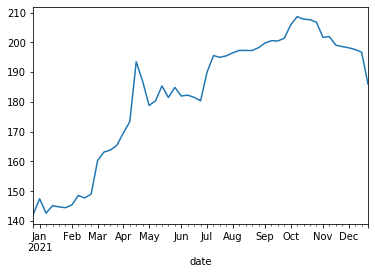

In [3]:
t = boston.calendar.groupby(pd.Grouper(key="date",freq="1W"))['price'].mean()[:-1].plot()
print('Figure shows the average price of listings throughout the year')

### Correlation between average number of listings and price throughout the year

In [4]:
stats_calendar = boston.calendar.groupby(pd.Grouper(key="date",freq="1W"))['price'].agg({'price':'mean','listing_id':'nunique'})
stats_calendar.reset_index(inplace=True)
stats_calendar.rename(columns={'price':'average_price','listing_id':'total_listings'},inplace=True)
stats_calendar = operation.normalize(stats_calendar,['average_price','total_listings'])
stats_calendar = stats_calendar[ stats_calendar.total_listings>0]

Figure shows the correlation between the number of listings and average price


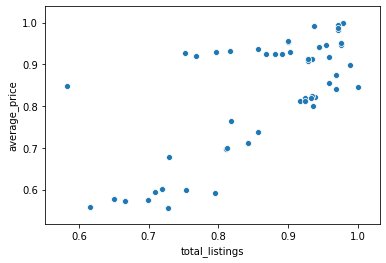

In [5]:
g = sns.scatterplot(data=stats_calendar, x="total_listings", y="average_price")
print('Figure shows the correlation between the number of listings and average price')

In [6]:
stats = boston.listings.groupby(['neighbourhood_cleansed','room_type'])['price'].agg(['mean','std','count'])
stats.reset_index(inplace=True)
stats.head(5)

,neighbourhood_cleansed,room_type,mean,std,count
0,Allston,Entire home/apt,167.246154,165.415200,65
1,Allston,Private room,66.741176,23.424221,85
2,Allston,Shared room,30.000000,NaN,1
3,Back Bay,Entire home/apt,175.098837,147.813129,172
4,Back Bay,Hotel room,143.333333,13.291601,6


### Average listing price in neighbourhoods per room type

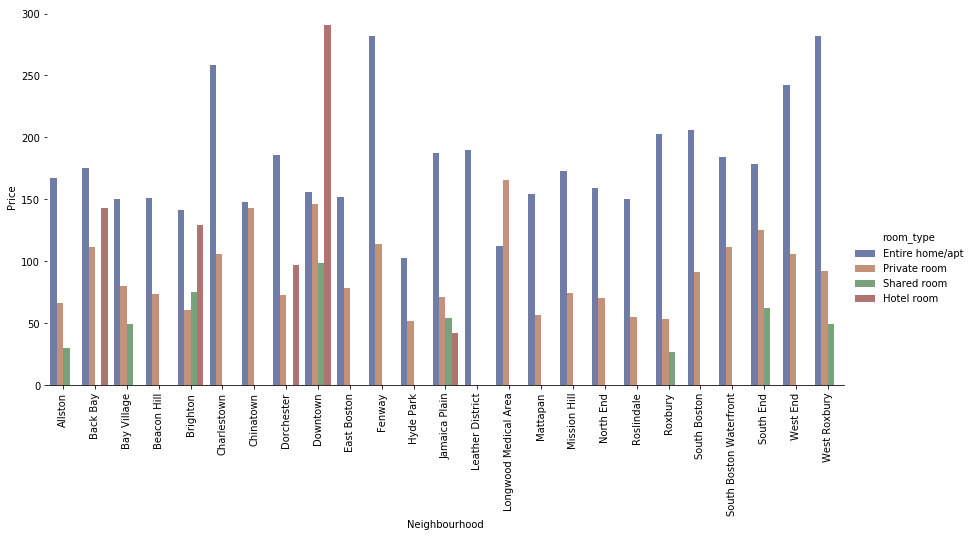

In [7]:
# Draw a nested barplot
g = sns.catplot(data=stats, kind="bar",
                x="neighbourhood_cleansed", y="mean", hue="room_type", 
                ci="sd", palette="dark", alpha=.6, height=6,aspect=2)
g = g.despine(left=True)
g = g.set_axis_labels("Neighbourhood", "Price")
g = g.set_xticklabels(rotation=90)

### Standard deviation among listing price of room types across neighbourhoods

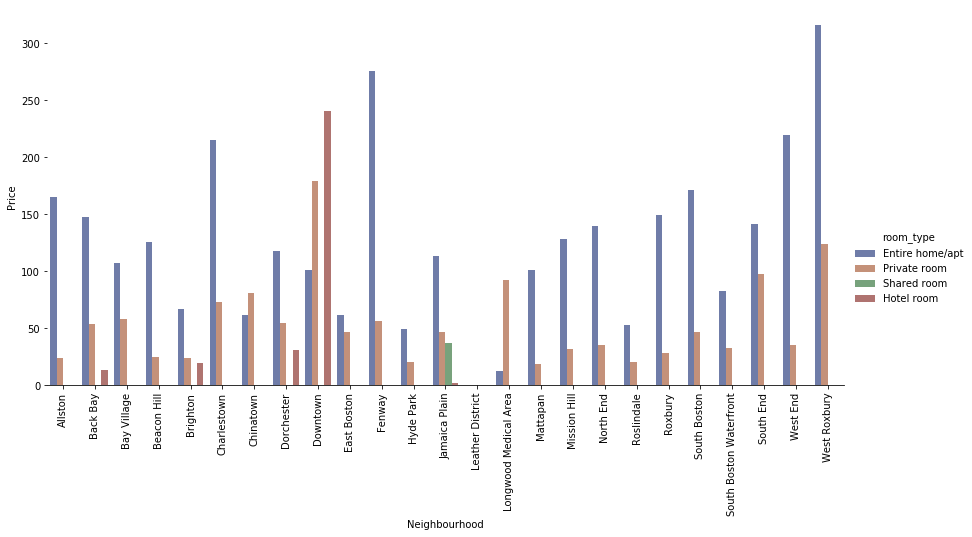

In [8]:
# Draw a nested barplot
g = sns.catplot(data=stats, kind="bar",
                x="neighbourhood_cleansed", y="std", hue="room_type", 
                ci="sd", palette="dark", alpha=.6, height=6,aspect=2)
g = g.despine(left=True)
g = g.set_axis_labels("Neighbourhood", "Price")
g = g.set_xticklabels(rotation=90)

# Modelling

### Feature selection and interpolation

In [9]:
cols = ['host_since','last_scraped','host_verifications','calculated_host_listings_count',
        'bedrooms','accommodates','beds','minimum_nights','maximum_nights',
        'neighbourhood_cleansed','room_type',
        'number_of_reviews','reviews_per_month','review_scores_rating',
        'price',
       'host_response_rate','host_acceptance_rate']

boston.listings = boston.listings[cols]

# Filling empty values with the mean
boston.listings = boston.listings.fillna(boston.listings.mean())

### Feature manipulation deduction and encoding

In [10]:
# Converting bedrooms type from float to int
boston.listings.bedrooms = boston.listings.bedrooms.astype('int')

# Remove characters from numerical features for casting as numerical
boston.listings.host_response_rate = boston.listings.host_response_rate.str.replace('%','').astype('float')
boston.listings.host_acceptance_rate = boston.listings.host_acceptance_rate.str.replace('%','').astype('float')

# Adding a feature to depict ad posters presence on platform in days since the ad
boston.listings['host_since_days'] = boston.listings[['host_since','last_scraped']].apply(operation.calculate_days,axis=1)
boston.listings.drop(columns=['host_since','last_scraped'],inplace=True)


def get_unique_features(df, column):
    '''
    INPUT:
    df - pandas pd.DataFrame containg the column, the column must contain a list for every record. 
         For reference look at the column amenities and host_verifications
    columns - python string containing a column name
    
    OUTPUT:
    unique_features - python list containing all unique occurrences present in the specified column
    
    The function returns the unique values present in a dataframe column that have list of values for each record
    '''
    unique_list = df[column].unique().tolist()
    unique_features = list()
    for i in unique_list:
        unique_features.extend(eval(i))
        unique_features = list(set(unique_features))
    print('{} column contains {} unique features'.format(column,len(unique_features)))
    print('{} features parsed and added'.format(column))
    return unique_features

def get_list_as_features(lst):
    '''
    INPUT:
    lst - takes a string list as an input, for example: '['hello','world']'
    
    OUTPUT:
    series - pandas pd.Series containing the list as features
    
    The function returns the features in a pandas.Series. 
    The function must be run after the function 'get_unique_features'.
    It uses the 'unique_features' returned from the 'get_unique_features' function.
    '''
    lst = eval(lst)
    series = pd.Series( index=unique_features,data=0 )
    series[lst] = 1
    return series

# Parsing the column 'host_verifications' into features (similar steps can be performed with 'amenities')
unique_features = get_unique_features(boston.listings, 'host_verifications')
boston.listings[unique_features] = boston.listings.host_verifications.apply(get_list_as_features)
boston.listings.drop(columns=['host_verifications'],inplace=True)

host_verifications column contains 18 unique features
host_verifications features parsed and added


In [11]:
# Getting encodings for categorical variables
boston.listings = pd.get_dummies(boston.listings,drop_first=True)

# Final data shape
print(boston.listings.shape)
boston.listings.head(1)

(3092, 58)


,calculated_host_listings_count,bedrooms,accommodates,beds,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month,review_scores_rating,price,host_response_rate,host_acceptance_rate,host_since_days,work_email,weibo,sent_id,kba,email,jumio,selfie,manual_online,identity_manual,sesame,reviews,offline_government_id,facebook,manual_offline,sesame_offline,google,government_id,phone,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_North End,neighbourhood_cleansed_Roslindale,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_South End,neighbourhood_cleansed_West End,neighbourhood_cleansed_West Roxbury,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,1,1,2,0.0,28,1125,17,0.26,99.0,132.0,100.0,31.0,4401,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model data split, training and validation

In [12]:
from sklearn.model_selection import train_test_split

X = boston.listings.iloc[:,boston.listings.columns != 'price']
y = boston.listings['price']

# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)

In [13]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# Create instace
xgb_reg = xgb.XGBRegressor(learning_rate=0.07,n_estimators=100,
                           gamma=5,colsample_bytree=0.3,subsample=0.5)

# Fit the model on training data
xgb_reg.fit(X_train, y_train)

# Predict
training_preds_xgb_reg = xgb_reg.predict(X_train)

# Validate
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))


Training MSE: 2971.8616
Validation MSE: 8166.2185

Training r2: 0.8264
Validation r2: 0.5349


## Model and Feature evaluation

#### Training set performance visualization

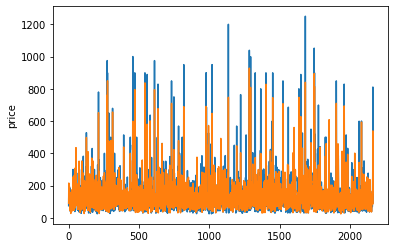

In [14]:
p = sns.lineplot(x=range(len(y_train)),y=y_train) # Blue
p = sns.lineplot(x=range(len(training_preds_xgb_reg)),y=training_preds_xgb_reg) # Orange

#### Validation set performance visualization

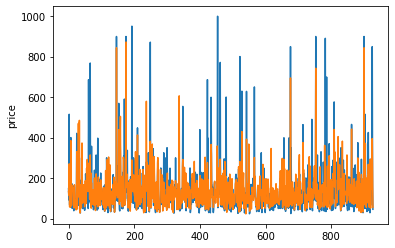

In [15]:
p = sns.lineplot(x=range(len(y_test)),y=y_test) # Blue
p = sns.lineplot(x=range(len(val_preds_xgb_reg)),y=val_preds_xgb_reg) # Orange

In [16]:
feature_importance = pd.DataFrame(data = {'features':X.columns,'importance':xgb_reg.feature_importances_})
feature_importance = feature_importance.sort_values(by='importance',ascending=False).reset_index(drop=True)
feature_importance

,features,importance
0,room_type_Private room,0.148110
1,bedrooms,0.062966
2,accommodates,0.062842
3,beds,0.044459
4,neighbourhood_cleansed_Bay Village,0.038133
5,neighbourhood_cleansed_Charlestown,0.033802
6,neighbourhood_cleansed_Fenway,0.030559
7,neighbourhood_cleansed_Back Bay,0.029332
8,neighbourhood_cleansed_West End,0.027246
9,neighbourhood_cleansed_North End,0.026315


# Sentiment analysis sample

In [17]:
sentiments_df = pd.DataFrame(data={'text':boston.reviews.comments[:10]})
sentiments_df[['polarity','strong_words']] = sentiments_df.text.apply(operation.get_sentiment)
sentiments_df

,text,polarity,strong_words
0,The apartment was as advertised and Frank was ...,0.300000,[incredibly]
1,It was a pleasure to stay at Frank's place. Th...,-0.150000,[base]
2,The apartment description is entirely faithful...,0.134375,"[very, very, nice, very]"
3,Thoroughly enjoyed my time at Frank's home. Ha...,0.387667,"[enjoyed, very, clean, very, happy, great, fan..."
4,Great value for the money! This location has e...,0.225000,"[great, !, very, really, free, !, very, calm, ..."
5,Frank was very accommodating throughout my sta...,0.281944,"[very, easy, detailed, seamless, clear, clean, !]"
6,Excellent! This was my second stay at the Jeff...,0.266667,"[excellent, !, extraordinarily]"
7,Frank was a wonderful and accommodating host. ...,0.433500,"[wonderful, exactly, very, clean, smooth, easy..."
8,"Frank was great, the apartment has everything ...",0.790625,"[great, lovely, !, !]"
9,Very nice. Comfortable apartment. Good locatio...,0.665000,"[very, nice, comfortable, good, very, nice]"


In [18]:
# Here you can see the Spacy making mistake classifying 'base' as a negative word
operation.get_sentiment("base")

0      -0.8
1    [base]
dtype: object